In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median
import numpyro_glm.ordinal.models as glm_ordinal
import numpyro_glm.ordinal.plots as ordinal_plots
import pandas as pd
import seaborn as sns

numpyro.set_host_device_count(4)

# Chapter 23: Ordinal Predicted Variable

## The Case of A Single Group

In [3]:
ord_1_df: pd.DataFrame = pd.read_csv('datasets/OrdinalProbitData-1grp-1.csv')
yord_1_cat = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)
ord_1_df['Y'] = ord_1_df['Y'].astype(yord_1_cat)

In [4]:
kernel = NUTS(glm_ordinal.yord_single_group,
              init_strategy=init_to_median,
              target_accept_prob=0.999)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(ord_1_df['Y'].cat.codes.values),
    K=yord_1_cat.categories.size,
)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.94      0.37      0.96      0.36      1.54  33306.76      1.00
     sigma      2.57      0.43      2.53      1.89      3.26  22945.41      1.00
   thres_2      2.52      0.25      2.50      2.11      2.92  25000.32      1.00
   thres_3      3.57      0.37      3.55      2.97      4.17  20351.60      1.00
   thres_4      4.62      0.44      4.63      3.89      5.34  19789.07      1.00
   thres_5      5.57      0.43      5.62      4.91      6.28  21077.21      1.00

Number of divergences: 42


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


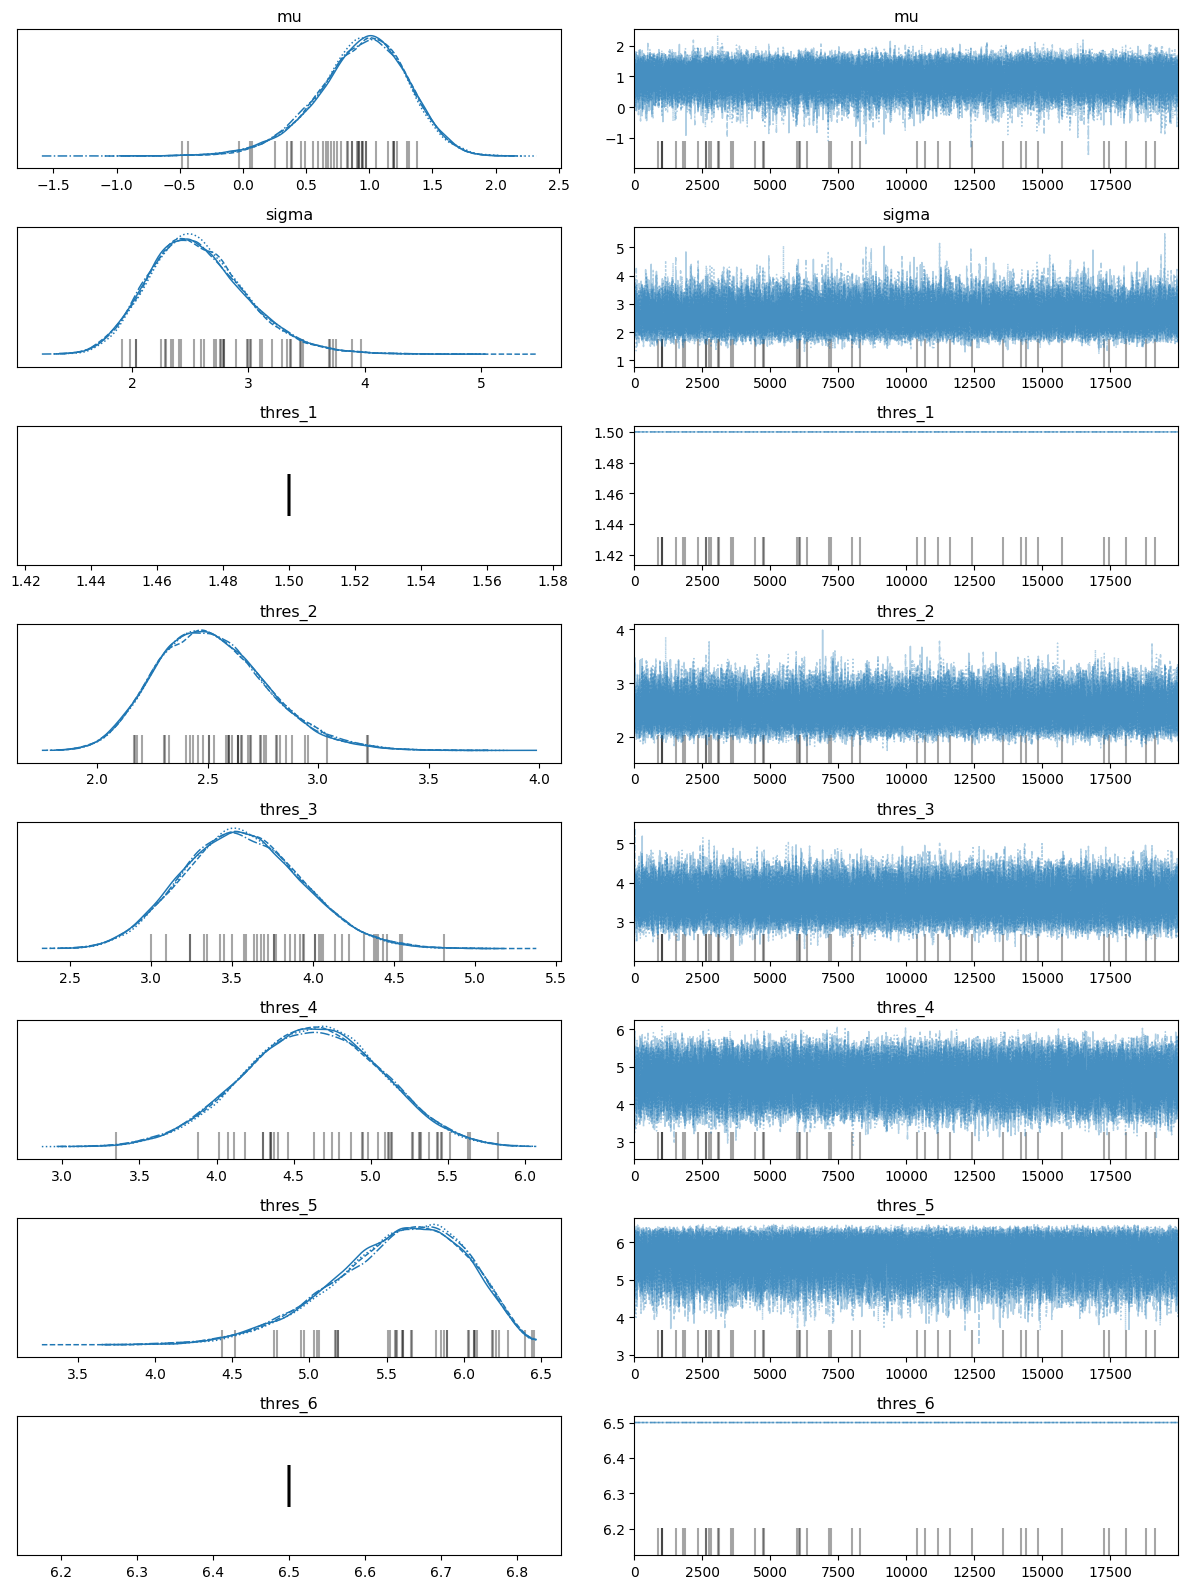

In [5]:
idata_yord_1 = az.from_numpyro(mcmc)
az.plot_trace(idata_yord_1)
plt.tight_layout()

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:68: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  probs_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)


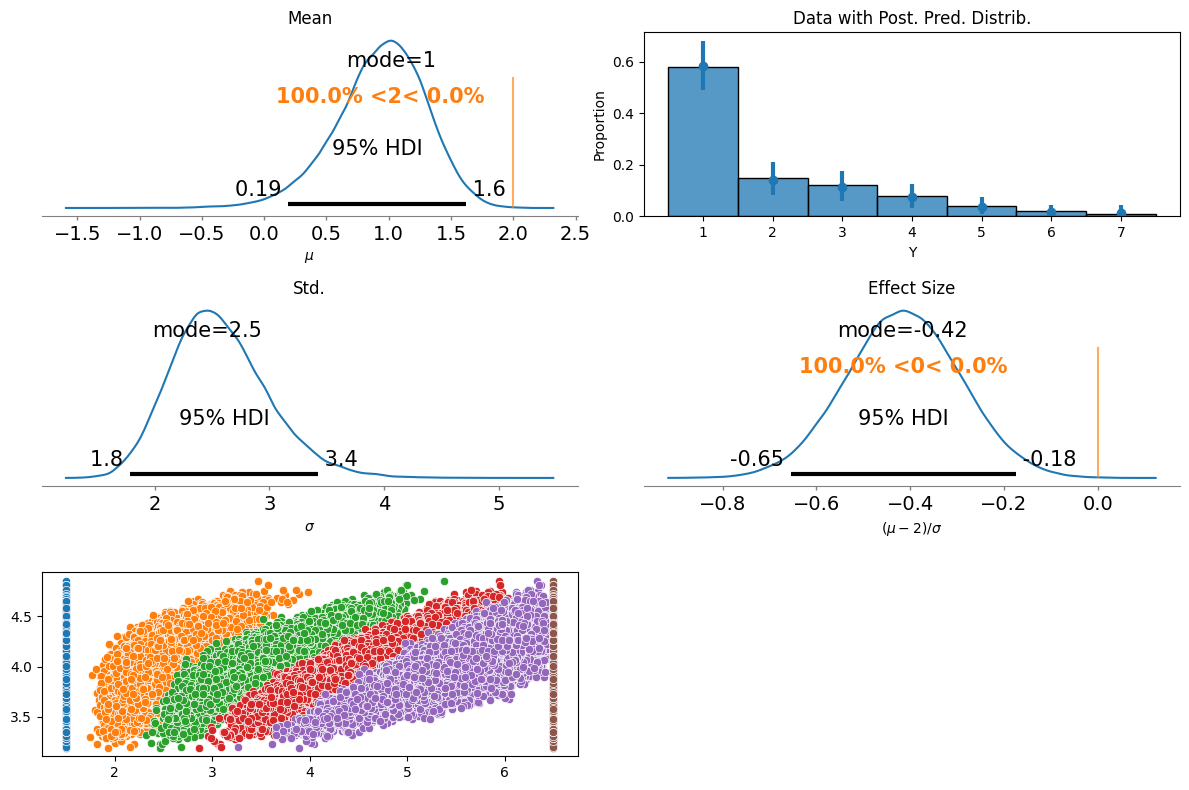

In [6]:
def plot_ordinal_one_group_results(idata, df, thresholds):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

    # Plot latent score's mean posterior distribution.
    ax = axes[0, 0]
    az.plot_posterior(
        idata,
        var_names='mu',
        hdi_prob=0.95,
        ref_val=2,
        point_estimate='mode',
        ax=ax)
    ax.set_title('Mean')
    ax.set_xlabel('$\mu$')

    # Plot data with posterior distribution.
    ax = axes[0, 1]
    ordinal_plots.plot_ordinal_data_with_posterior(
        idata, 'mu', 'sigma', thresholds,
        df, ordinal_predicted='Y',
        ax=ax)
    ax.set_title('Data with Post. Pred. Distrib.')

    # Plot latent score's standard deviation.
    ax = axes[1, 0]
    az.plot_posterior(
        idata,
        var_names='sigma',
        hdi_prob=0.95,
        point_estimate='mode',
        ax=ax)
    ax.set_title('Std.')
    ax.set_xlabel('$\sigma$')

    # Plot effect size.
    ax = axes[1, 1]
    posterior = idata.posterior
    eff_size = (posterior['mu'] - 2) / posterior['sigma']
    az.plot_posterior(
        eff_size,
        hdi_prob=0.95,
        point_estimate='mode',
        ref_val=0,
        ax=ax)
    ax.set_title('Effect Size')
    ax.set_xlabel('$(\mu - 2) / \sigma$')

    # Plot thresholds.
    ax = axes[2, 0]
    ordinal_plots.plot_threshold_scatter(idata, thresholds, ax=ax)

    axes[2, 1].remove()
    fig.tight_layout()


thresholds = ['thres_1', 'thres_2', 'thres_3', 'thres_4', 'thres_5', 'thres_6']
plot_ordinal_one_group_results(idata_yord_1, ord_1_df, thresholds)

---

The same model but applied on different dataset.

In [7]:
ord_2_df: pd.DataFrame = pd.read_csv('datasets/OrdinalProbitData-1grp-2.csv')
yord_2_cat = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)
ord_2_df['Y'] = ord_2_df['Y'].astype(yord_2_cat)

In [8]:
kernel = NUTS(glm_ordinal.yord_single_group,
              init_strategy=init_to_median,
              target_accept_prob=0.99)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(ord_2_df['Y'].cat.codes.values),
    K=yord_2_cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.60      0.27      3.60      3.14      4.04  20265.96      1.00
     sigma      1.61      0.18      1.60      1.32      1.90  32278.40      1.00
   thres_2      3.34      0.27      3.33      2.89      3.78  17942.76      1.00
   thres_3      3.87      0.28      3.87      3.41      4.35  15544.34      1.00
   thres_4      4.32      0.30      4.32      3.84      4.81  15125.79      1.00
   thres_5      4.90      0.31      4.91      4.39      5.40  16550.44      1.00

Number of divergences: 3


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


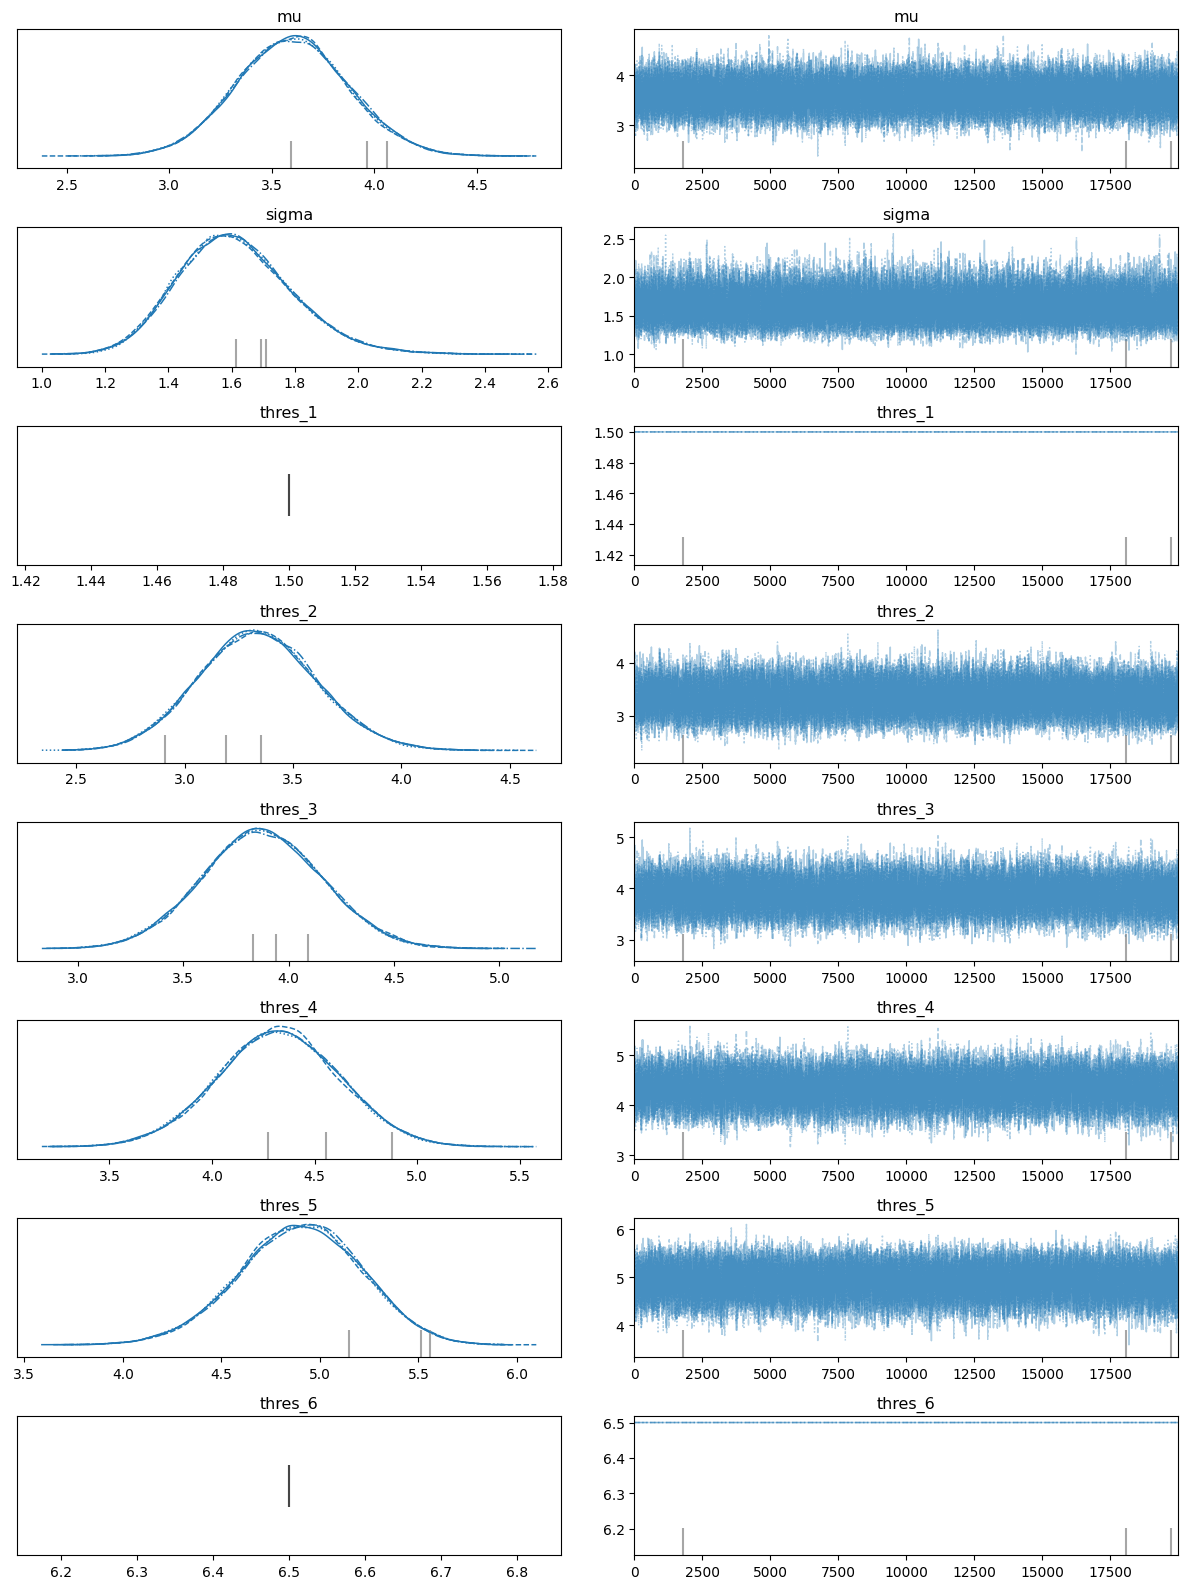

In [9]:
idata_yord_2 = az.from_numpyro(mcmc)
az.plot_trace(idata_yord_2)
plt.tight_layout()

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:68: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  probs_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)


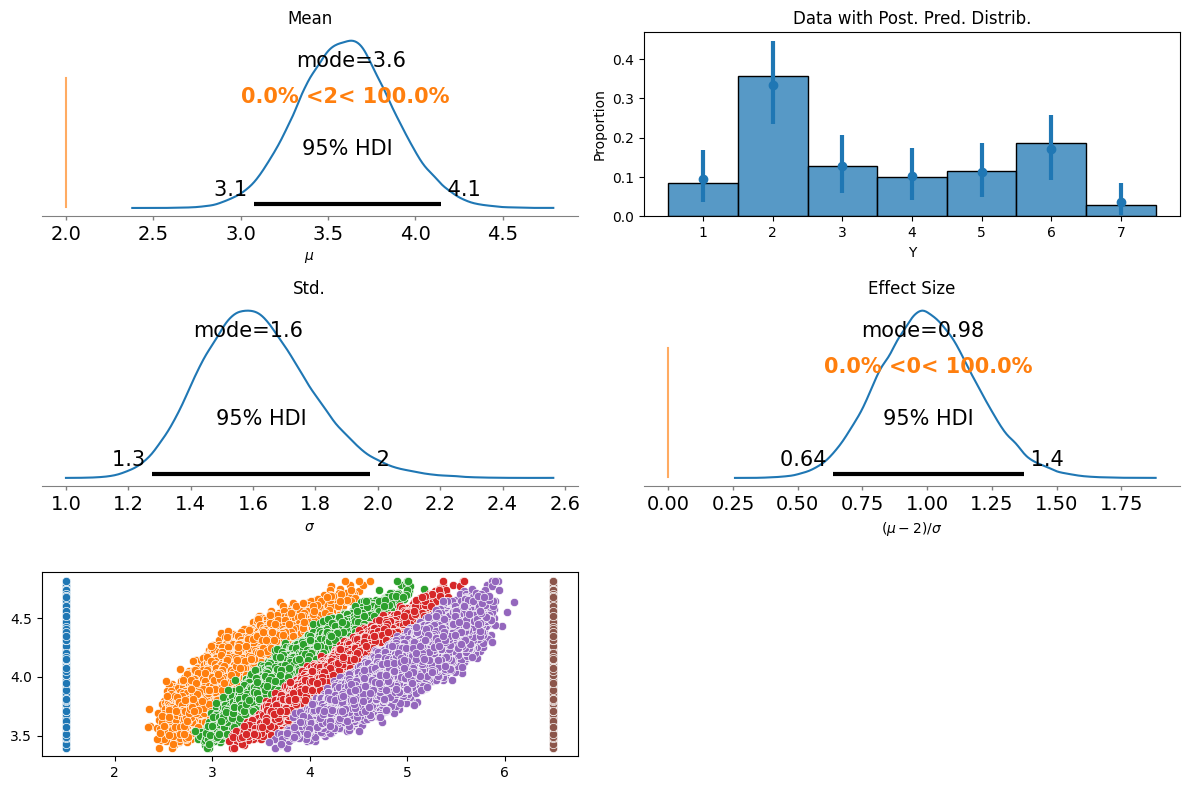

In [10]:
plot_ordinal_one_group_results(idata_yord_2, ord_2_df, thresholds)

## The Case of Two Groups

In [11]:
two_groups_df: pd.DataFrame = pd.read_csv('datasets/OrdinalProbitData1.csv')
two_groups_ordinal_cat = pd.CategoricalDtype([1, 2, 3, 4, 5], ordered=True)
two_groups_df['Y'] = two_groups_df['Y'].astype(two_groups_ordinal_cat)
two_groups_df['X'] = two_groups_df['X'].astype('category')
two_groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X       88 non-null     category
 1   Y       88 non-null     category
dtypes: category(2)
memory usage: 640.0 bytes


In [12]:
kernel = NUTS(glm_ordinal.yord_two_groups,
              init_strategy=init_to_median,
              target_accept_prob=0.99)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(two_groups_df['Y'].cat.codes.values),
    grp=jnp.array(two_groups_df['X'].cat.codes.values),
    K=two_groups_ordinal_cat.categories.size,
    nb_groups=two_groups_df['X'].cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      0.48      0.55      0.58     -0.32      1.29  22236.70      1.00
     mu[1]      1.42      0.34      1.45      0.90      1.99  33344.18      1.00
  sigma[0]      1.75      0.56      1.66      0.93      2.58  22212.36      1.00
  sigma[1]      1.73      0.38      1.68      1.14      2.30  31020.88      1.00
   thres_2      2.56      0.23      2.54      2.17      2.93  32010.16      1.00
   thres_3      3.60      0.30      3.61      3.12      4.10  30960.35      1.00

Number of divergences: 188


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


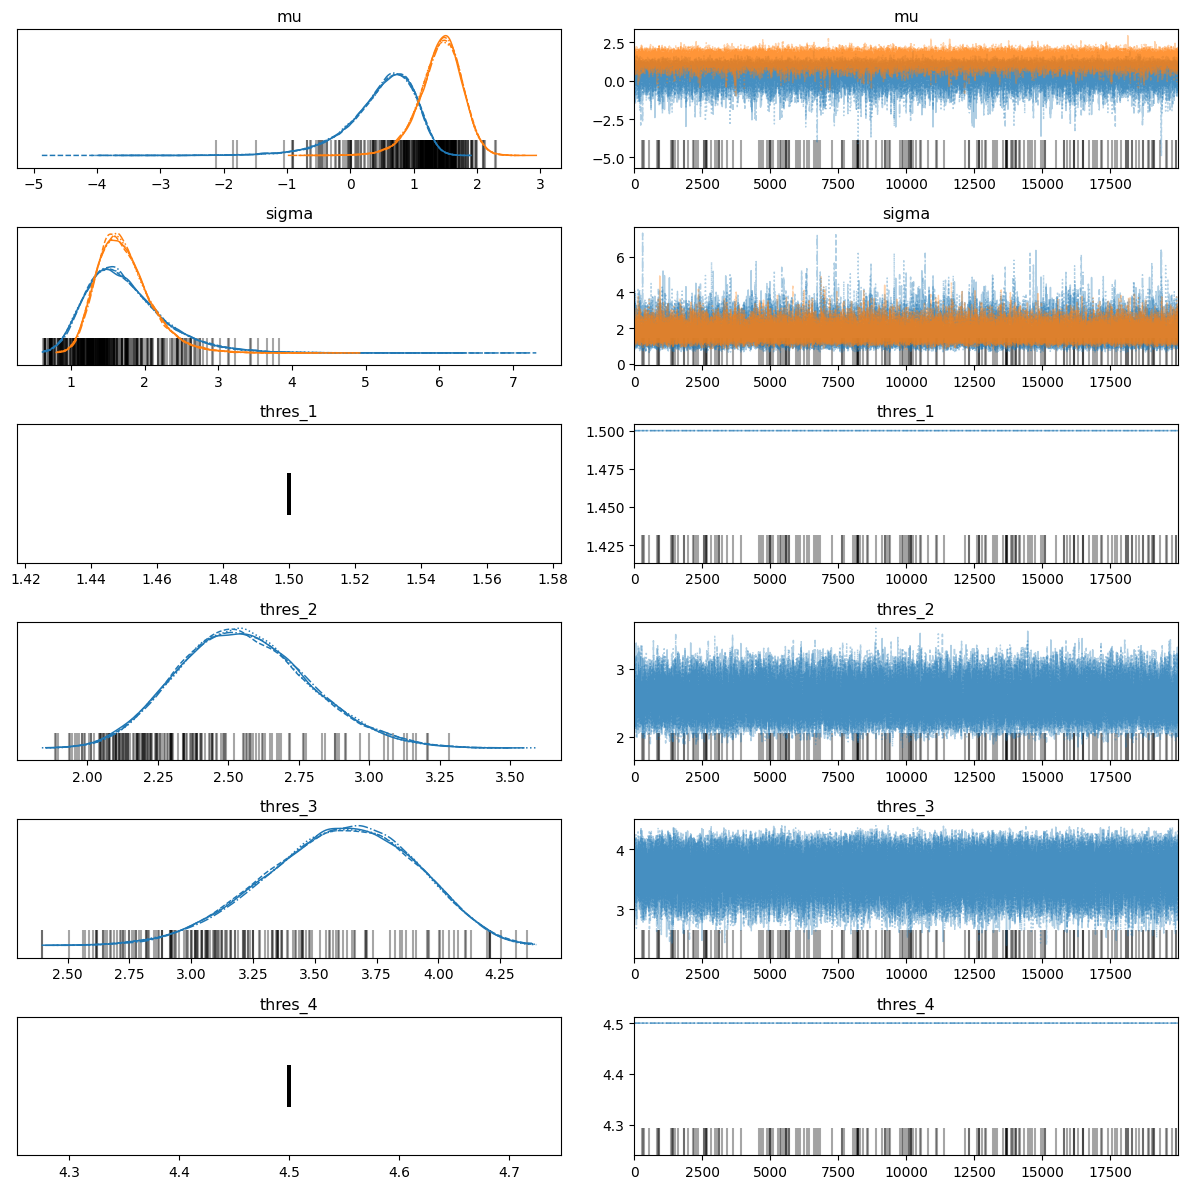

In [13]:
idata_two_groups = az.from_numpyro(
    mcmc,
    coords=dict(group=two_groups_df['X'].cat.categories),
    dims=dict(sigma=['group'], mu=['group'])
)
az.plot_trace(idata_two_groups)
plt.tight_layout()

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:68: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  probs_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)
/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:68: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  probs_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)


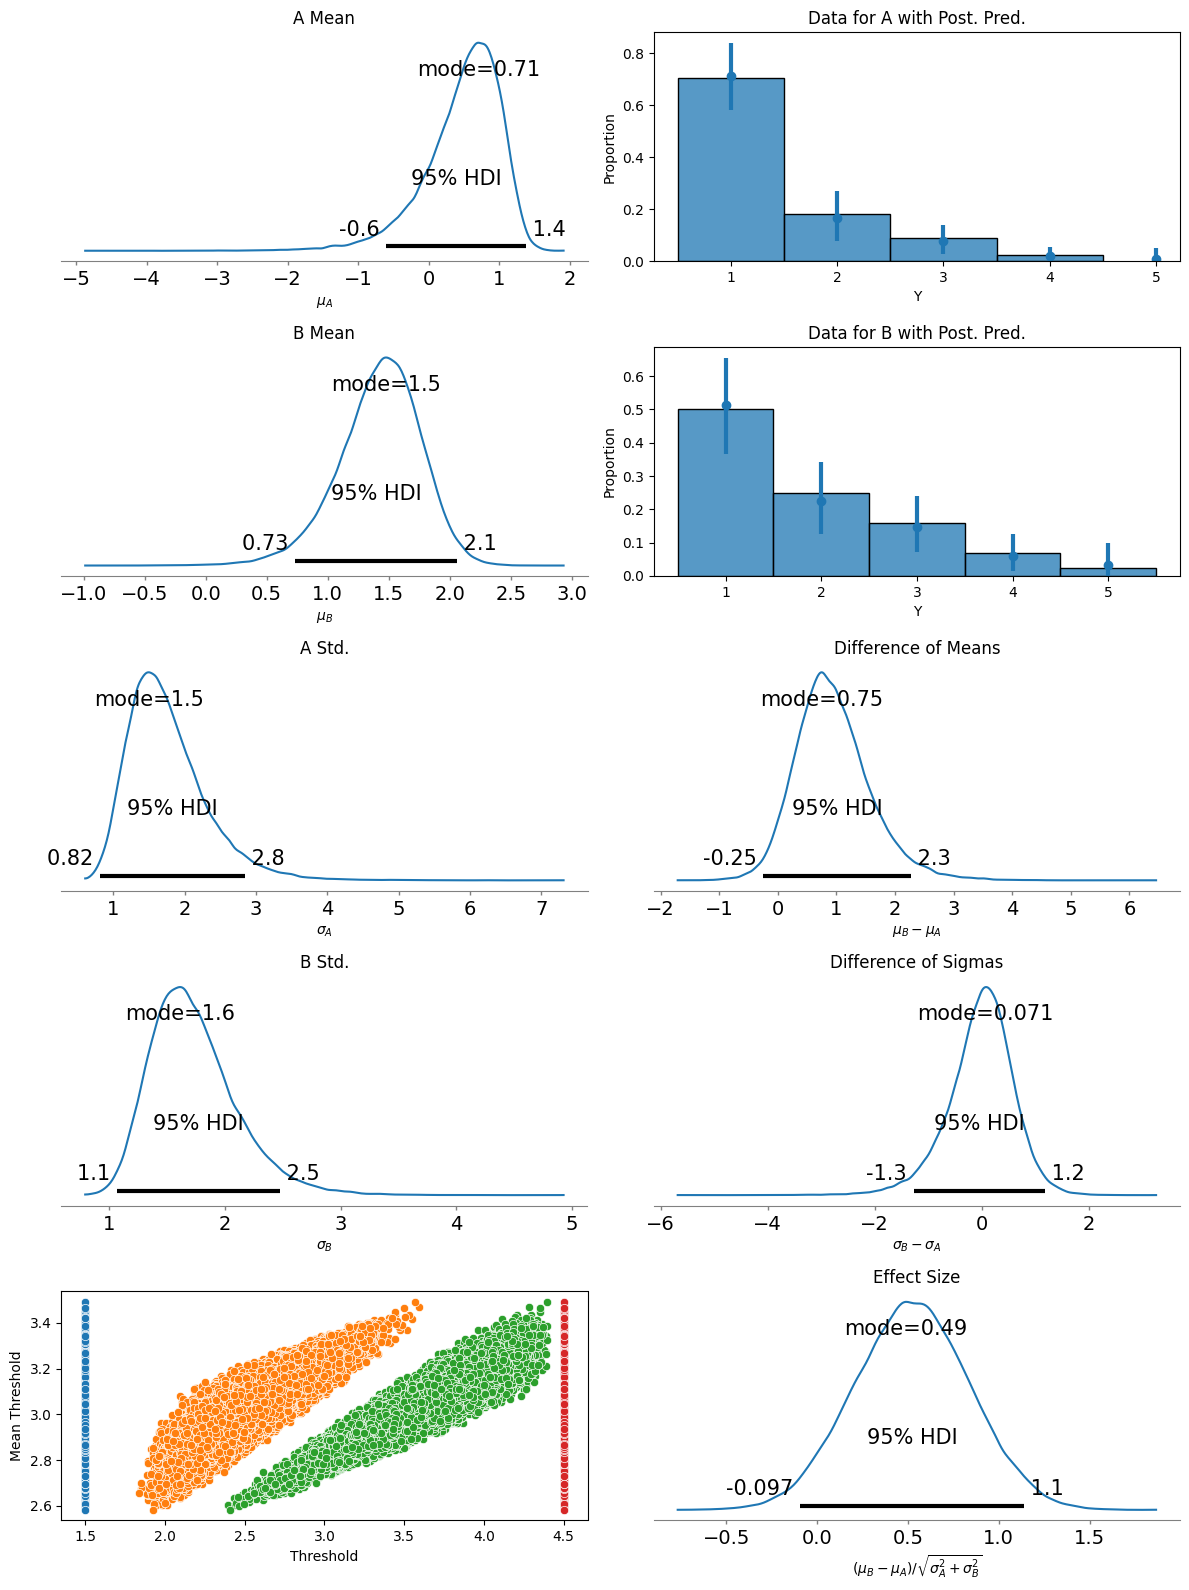

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))

# Plot group A's latent mean.
ax = axes[0, 0]
az.plot_posterior(
    idata_two_groups,
    var_names='mu',
    coords=dict(group='A'),
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('A Mean')
ax.set_xlabel('$\mu_A$')

# Plot group A's data with posterior distrib.
ax = axes[0, 1]
ordinal_plots.plot_ordinal_data_with_posterior(
    idata_two_groups,
    'mu', 'sigma',
    ['thres_1', 'thres_2', 'thres_3', 'thres_4'],
    latent_coords=dict(group='A'),
    data=two_groups_df[two_groups_df['X'] == 'A'],
    ordinal_predicted='Y',
    ax=ax,
)
ax.set_title('Data for A with Post. Pred.')

# Plot group B's latent mean.
ax = axes[1, 0]
az.plot_posterior(
    idata_two_groups,
    var_names='mu',
    coords=dict(group='B'),
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('B Mean')
ax.set_xlabel('$\mu_B$')

# Plot group B's data with posterior distrib.
ax = axes[1, 1]
thresholds = ['thres_1', 'thres_2', 'thres_3', 'thres_4']
ordinal_plots.plot_ordinal_data_with_posterior(
    idata_two_groups,
    'mu', 'sigma',
    thresholds,
    latent_coords=dict(group='B'),
    data=two_groups_df[two_groups_df['X'] == 'B'],
    ordinal_predicted='Y',
    ax=ax,
)
ax.set_title('Data for B with Post. Pred.')

# Plot A's standard deviation.
ax = axes[2, 0]
az.plot_posterior(
    idata_two_groups,
    var_names='sigma',
    coords=dict(group='A'),
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('A Std.')
ax.set_xlabel('$\sigma_A$')

# Plot difference of means.
posterior = idata_two_groups['posterior']
ax = axes[2, 1]
mean_diff = (posterior['mu'].sel(group='B')
             - posterior['mu'].sel(group='A'))
az.plot_posterior(
    mean_diff,
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('Difference of Means')
ax.set_xlabel('$\mu_B - \mu_A$')

# Plot B's standard deviation.
ax = axes[3, 0]
az.plot_posterior(
    idata_two_groups,
    var_names='sigma',
    coords=dict(group='B'),
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('B Std.')
ax.set_xlabel('$\sigma_B$')

# Plot difference of sigmas.
ax = axes[3, 1]
sigma_diff = (posterior['sigma'].sel(group='B')
              - posterior['sigma'].sel(group='A'))
az.plot_posterior(
    sigma_diff,
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('Difference of Sigmas')
ax.set_xlabel('$\sigma_B - \sigma_A$')

# Plot threshold scatter.
ax = axes[4, 0]
ordinal_plots.plot_threshold_scatter(
    idata_two_groups,
    thresholds,
    ax=ax
)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Threshold')

# Plot effect size.
ax = axes[4, 1]
sigma_squared = (posterior['sigma'].sel(group='A')**2
                 + posterior['sigma'].sel(group='B')**2)
eff_size = mean_diff / np.sqrt(sigma_squared / 2)
az.plot_posterior(
    eff_size,
    point_estimate='mode',
    hdi_prob=0.95,
    ax=ax)
ax.set_title('Effect Size')
ax.set_xlabel('$(\mu_B - \mu_A) / \sqrt{\sigma_A^2 + \sigma_B^2}$')

fig.tight_layout()

## The Case of Metric Predictors
### Example: Happiness and Money

In [15]:
happiness_cat = pd.CategoricalDtype([1, 2, 3, 4, 5], ordered=True)
happiness_df: pd.DataFrame = pd.read_csv(
    'datasets/HappinessAssetsDebt.csv',
    dtype={'Happiness': happiness_cat})
happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6759 entries, 0 to 6758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Happiness  6759 non-null   category
 1   Assets     6759 non-null   float64 
 2   Debt       6759 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 112.5 KB


(4.5, -0.5)


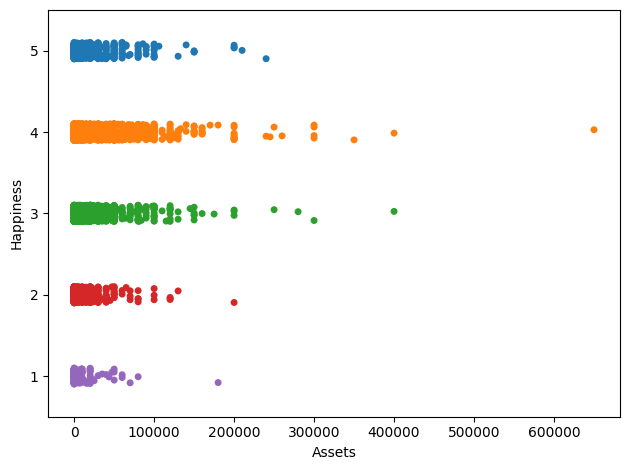

In [16]:
happiness_fig, happiness_ax = plt.subplots()
sns.stripplot(
    x='Assets', y='Happiness',
    data=happiness_df,
    order=happiness_cat.categories[::-1],
    ax=happiness_ax)
happiness_fig.tight_layout()
print(happiness_ax.get_ylim())

In [17]:
kernel = NUTS(glm_ordinal.yord_metric_predictors,
              init_strategy=init_to_median)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(happiness_df['Happiness'].cat.codes.values),
    x=jnp.array(happiness_df[['Assets']].values),
    K=happiness_cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _a[0]      0.13      0.01      0.13      0.11      0.15   7915.32      1.00
       _a0      3.23      0.02      3.23      3.21      3.26   4493.11      1.00
     sigma      0.85      0.01      0.85      0.84      0.87   6590.97      1.00
   thres_2      2.24      0.02      2.24      2.20      2.28   3925.47      1.00
   thres_3      3.10      0.02      3.10      3.07      3.13   4308.13      1.00

Number of divergences: 0


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


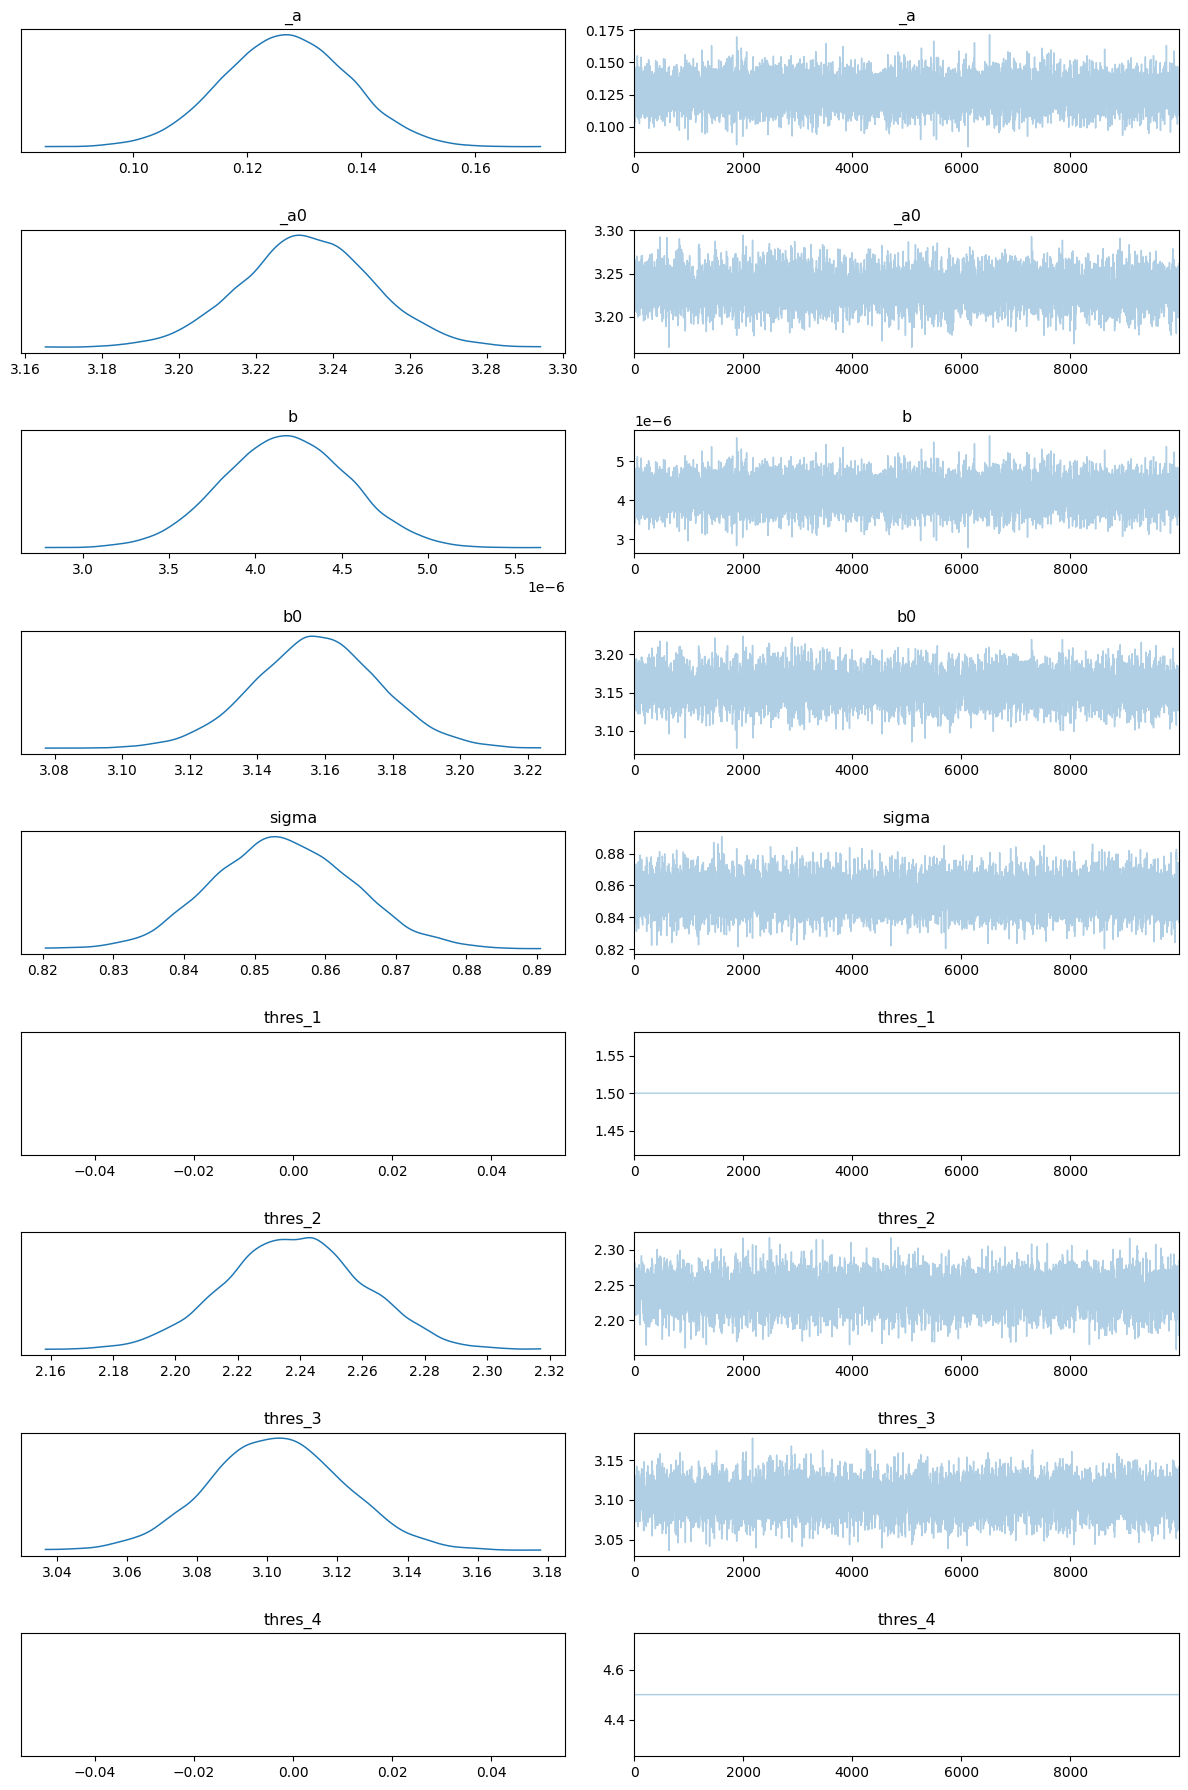

In [18]:
idata_happiness = az.from_numpyro(
    mcmc,
    coords=dict(pred=['Assets']),
    dims=dict(b=['pred'])
)
az.plot_trace(idata_happiness, var_names='~mu')
plt.tight_layout()

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:134: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  err_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)
/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:134: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  err_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)
/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian/numpyro_glm/ordinal/plots.py:134: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  err_95_hdi = az.hdi(probs.T - probs_median[None, :], hdi_prob=.95)
/home/runner/work/numpyro

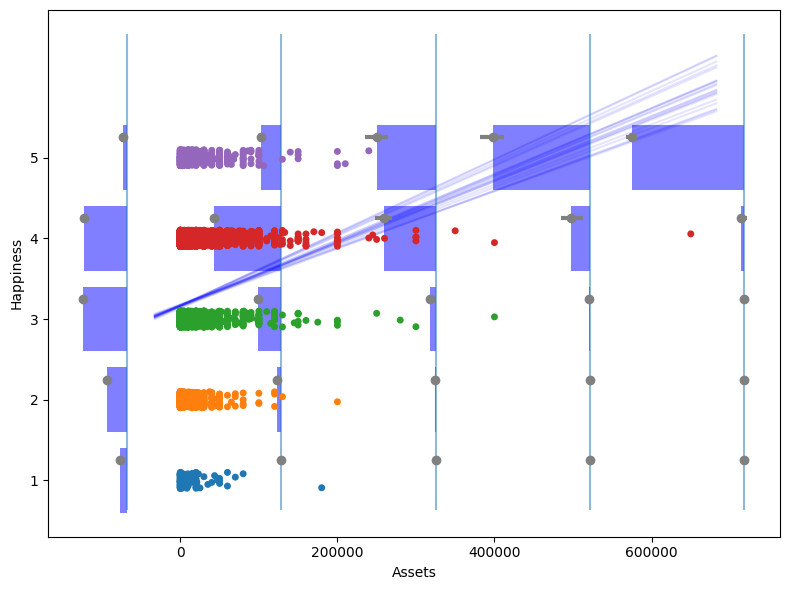

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ordinal_plots.plot_ordinal_data_with_linear_trend_and_posterior(
    idata_happiness,
    latent_intercept='b0',
    latent_coef='b',
    latent_sigma='sigma',
    thresholds=['thres_1', 'thres_2', 'thres_3', 'thres_4'],
    data=happiness_df,
    ordinal_predicted='Happiness',
    metric_predictor='Assets',
    ax=ax
)
ax.invert_yaxis()
fig.tight_layout()

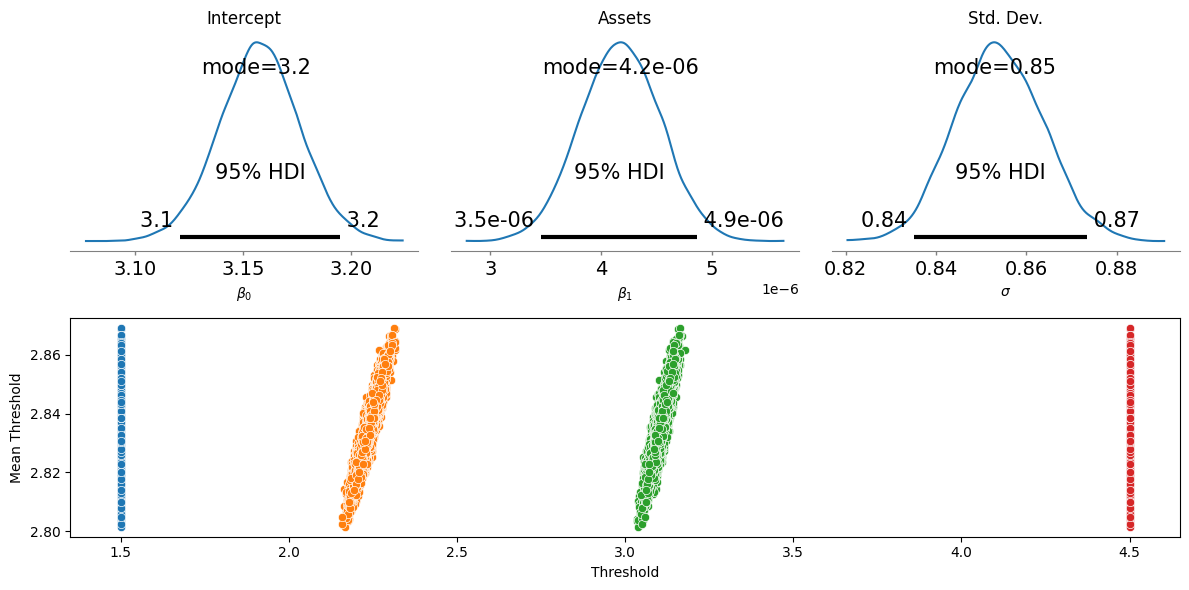

In [20]:
fig: plt.Figure = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=2, ncols=3)

# Plot intercept posterior distribution.
ax: plt.Axes = fig.add_subplot(gs[0, 0])
az.plot_posterior(
    idata_happiness, 'b0', hdi_prob=.95, point_estimate='mode', ax=ax)
ax.set_title('Intercept')
ax.set_xlabel('$\\beta_0$')

# Plot coefficient for assets.
ax: plt.Axes = fig.add_subplot(gs[0, 1])
az.plot_posterior(
    idata_happiness,
    'b', coords=dict(pred='Assets'),
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Assets')
ax.set_xlabel('$\\beta_1$')

# Plot standard deviation.
ax: plt.Axes = fig.add_subplot(gs[0, 2])
az.plot_posterior(
    idata_happiness,
    'sigma',
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Std. Dev.')
ax.set_xlabel('$\\sigma$')

# Plot thresholds scatter.
ax: plt.Axes = fig.add_subplot(gs[1, :])
ordinal_plots.plot_threshold_scatter(
    idata_happiness,
    ['thres_1', 'thres_2', 'thres_3', 'thres_4'],
    ax=ax,
)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Threshold')

fig.tight_layout()

### Example: Movies - They don't make 'em like they used to

In [21]:
rating_cat = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 7], ordered=True)
movies_df: pd.DataFrame = pd.read_csv('datasets/Movies.csv')
movies_df['Rating'] = (movies_df['Rating']
                       .map({1: 1,
                             1.5: 2,
                             2: 3,
                             2.5: 4,
                             3: 5,
                             3.5: 6,
                             4: 7})
                       .astype(rating_cat))
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Title        100 non-null    object  
 1   Year         100 non-null    int64   
 2   Length       100 non-null    int64   
 3   Cast         100 non-null    int64   
 4   Rating       100 non-null    category
 5   Description  100 non-null    int64   
dtypes: category(1), int64(4), object(1)
memory usage: 4.5+ KB


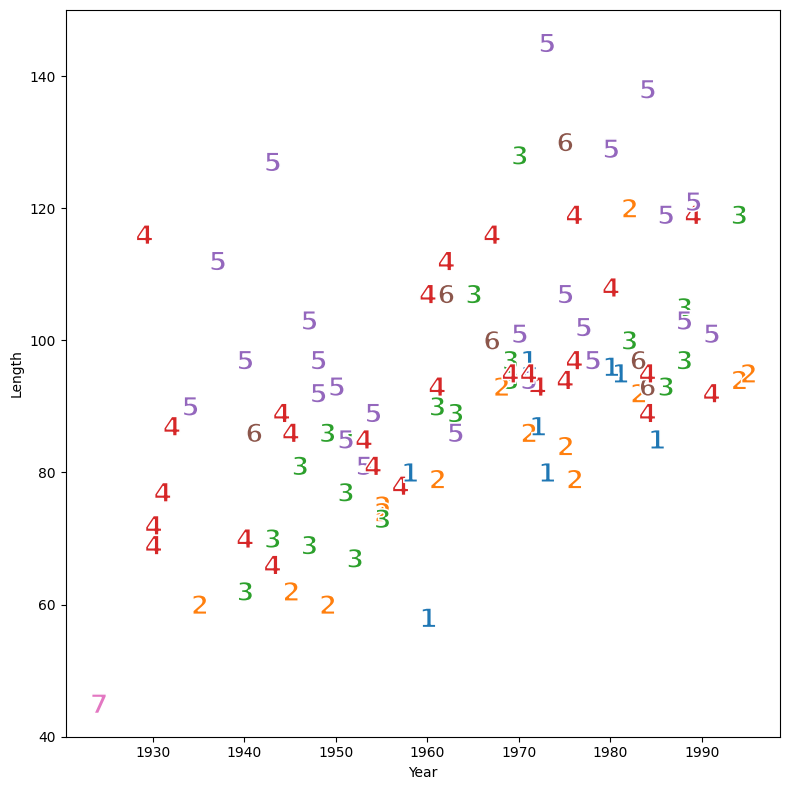

In [22]:
fig_movies, ax_movies = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x='Year', y='Length',
    hue='Rating',
    style='Rating',
    markers={r: f'$\\mathbf{{{r}}}$' for r in rating_cat.categories},
    s=200,
    data=movies_df,
    legend=False,
    ax=ax_movies)
fig_movies.tight_layout()

In [23]:
kernel = NUTS(glm_ordinal.yord_metric_predictors,
              init_strategy=init_to_median,
              target_accept_prob=.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(movies_df['Rating'].cat.codes.values),
    x=jnp.array(movies_df[['Year', 'Length']].values),
    K=rating_cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _a[0]     -0.59      0.16     -0.59     -0.85     -0.33  40239.76      1.00
     _a[1]      0.76      0.17      0.76      0.48      1.03  35367.92      1.00
       _a0      3.53      0.22      3.53      3.18      3.89  25921.02      1.00
     sigma      1.28      0.12      1.27      1.08      1.49  37120.87      1.00
   thres_2      2.41      0.19      2.40      2.08      2.72  30582.18      1.00
   thres_3      3.27      0.23      3.27      2.90      3.64  25064.18      1.00
   thres_4      4.30      0.26      4.30      3.87      4.73  23381.12      1.00
   thres_5      5.60      0.29      5.63      5.15      6.07  26255.95      1.00

Number of divergences: 28


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


/opt/hostedtoolcache/Python/3.10.10/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


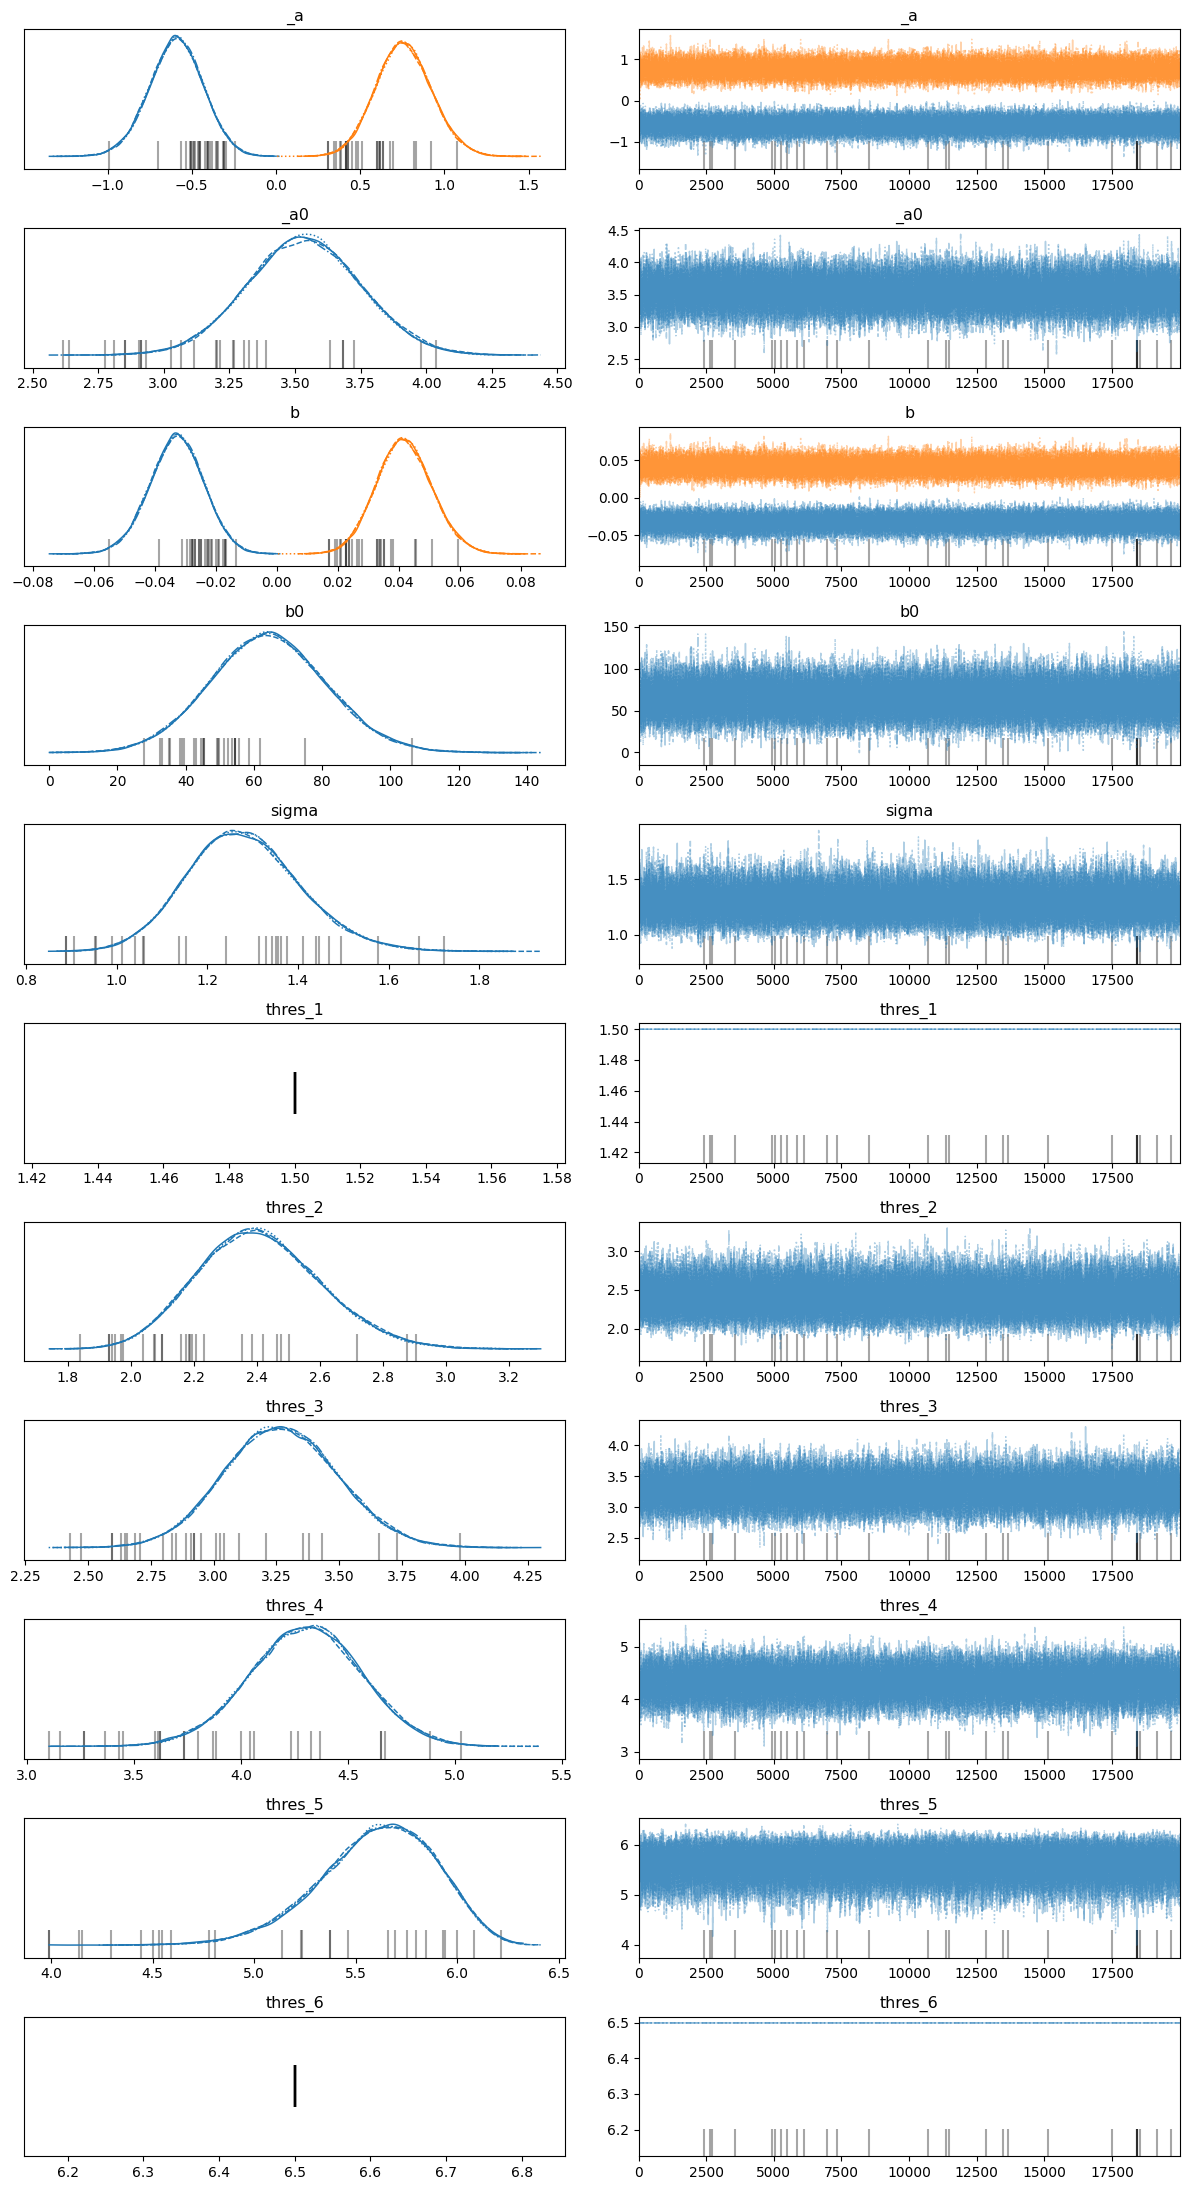

In [24]:
idata_movies = az.from_numpyro(
    mcmc,
    coords=dict(pred=['Year', 'Length']),
    dims=dict(b=['pred'])
)
az.plot_trace(idata_movies, '~mu')
plt.tight_layout()

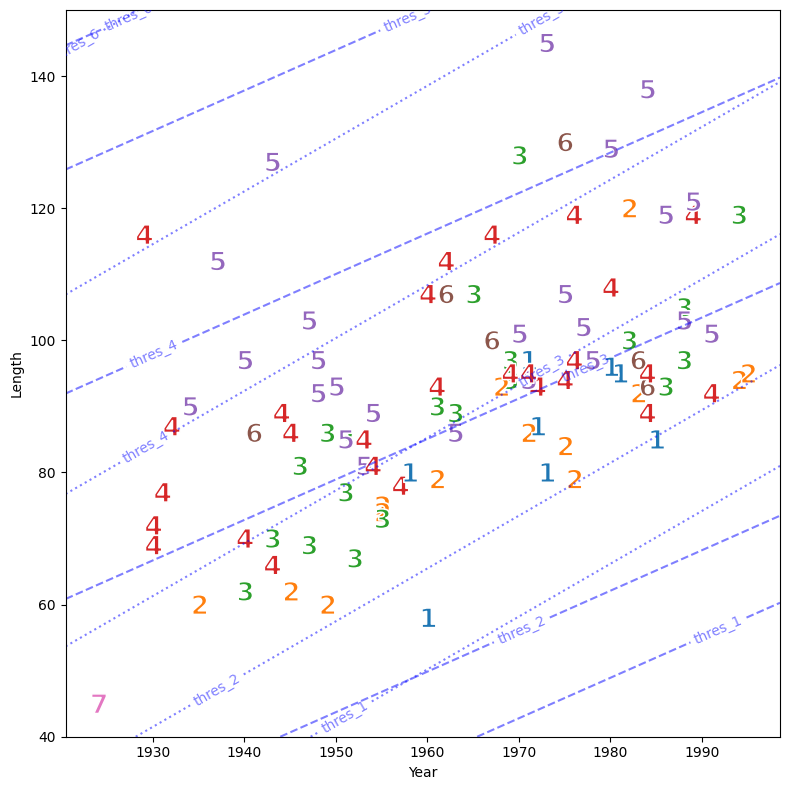

In [25]:
def superimpose_posterior_threshold_lines(
        idata: az.InferenceData, *,
        n_steps: int,
        latent_intercept: str,
        latent_coef: str,
        first_coord: dict,
        second_coord: dict,
        thresholds: 'list[str]',
        ax: plt.Axes):
    assert n_steps <= 3

    # Obtain the MCMC samples.
    posterior = idata['posterior']
    b0 = posterior[latent_intercept].values.flatten()
    b1 = posterior[latent_coef].sel(first_coord).values.flatten()
    b2 = posterior[latent_coef].sel(second_coord).values.flatten()
    thres = np.asarray([posterior[f'{t}'].values.flatten()
                        for t in thresholds])

    # Steps to plot.
    step_indices = np.random.choice(
        posterior['draw'].size * posterior['chain'].size,
        n_steps, replace=False)

    # Assumption: the y-axis will correspond with `b1`
    # and the x-axis will correspond with `b2`.
    yy, xx = np.meshgrid(
        np.linspace(*ax.get_ylim(), 1000),
        np.linspace(*ax.get_xlim(), 1000),
        indexing='ij',
    )

    linestyles = ['dashed', 'dotted', 'dashdot']
    for idx, ls in zip(step_indices, linestyles):
        mu = b0[idx] + b1[idx] * yy + b2[idx] * xx
        cs = ax.contour(
            xx, yy, mu,
            levels=thres[:, idx],
            colors='blue', alpha=.5, linestyles=ls)
        ax.clabel(
            cs, levels=thres[:, idx],
            fmt={lv: lb for lv, lb in zip(cs.levels, thresholds)})


superimpose_posterior_threshold_lines(
    idata_movies,
    n_steps=2,
    latent_intercept='b0',
    latent_coef='b',
    first_coord=dict(pred='Length'),
    second_coord=dict(pred='Year'),
    thresholds=['thres_1', 'thres_2', 'thres_3',
                'thres_4', 'thres_5', 'thres_6'],
    ax=ax_movies)

# Show the result.
fig_movies

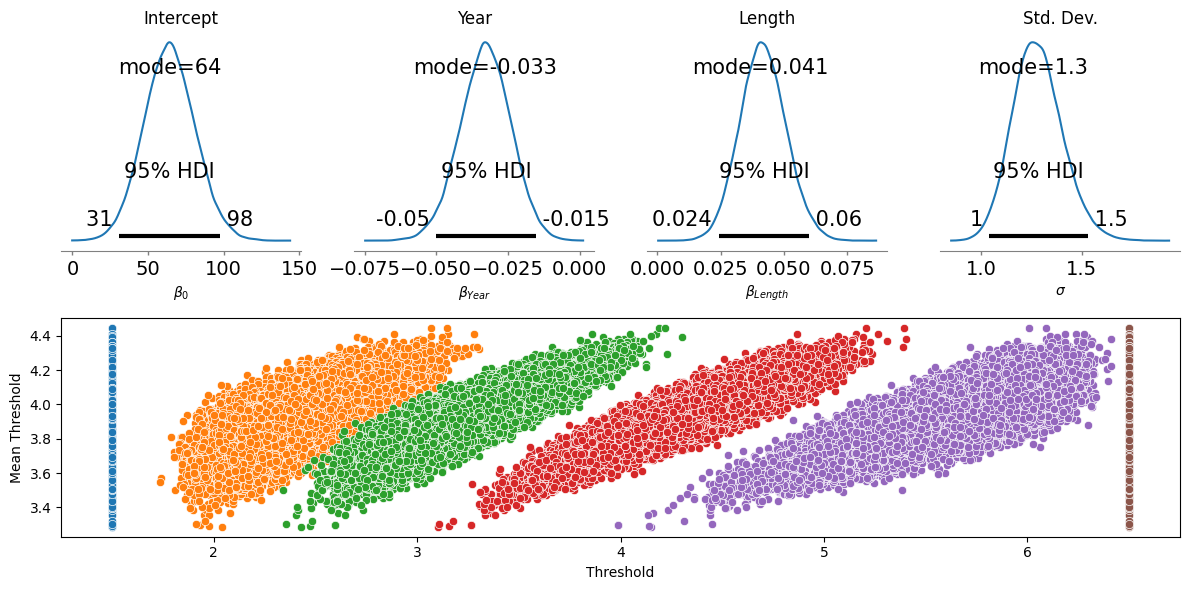

In [26]:
fig: plt.Figure = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=2, ncols=4)

# Plot intercept posterior distribution.
ax: plt.Axes = fig.add_subplot(gs[0, 0])
az.plot_posterior(
    idata_movies, 'b0', hdi_prob=.95, point_estimate='mode', ax=ax)
ax.set_title('Intercept')
ax.set_xlabel('$\\beta_0$')

# Plot coefficient for year.
ax: plt.Axes = fig.add_subplot(gs[0, 1])
az.plot_posterior(
    idata_movies,
    'b', coords=dict(pred='Year'),
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Year')
ax.set_xlabel('$\\beta_{Year}$')

# Plot coefficient for length.
ax: plt.Axes = fig.add_subplot(gs[0, 2])
az.plot_posterior(
    idata_movies,
    'b', coords=dict(pred='Length'),
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Length')
ax.set_xlabel('$\\beta_{Length}$')

# Plot standard deviation.
ax: plt.Axes = fig.add_subplot(gs[0, 3])
az.plot_posterior(
    idata_movies,
    'sigma',
    hdi_prob=.95, point_estimate='mode',
    ax=ax)
ax.set_title('Std. Dev.')
ax.set_xlabel('$\\sigma$')

# Plot thresholds scatter.
ax: plt.Axes = fig.add_subplot(gs[1, :])
ordinal_plots.plot_threshold_scatter(
    idata_movies,
    ['thres_1', 'thres_2', 'thres_3', 'thres_4', 'thres_5', 'thres_6'],
    ax=ax,
)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Threshold')

fig.tight_layout()